### Pairs Trading using Kalman Filtering

Piyush Babar (22B3909)

In [17]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib
from pykalman import KalmanFilter
from datetime import datetime
from numpy import log, polyfit, sqrt, std, subtract
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
import warnings
warnings.filterwarnings('ignore')

In [18]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
pdr.get_data_yahoo = pdr.get_data_yahoo

In [19]:
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2017, 1, 1)

tickers = ['ADBE', 'MSFT']


df = yf.download(tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  2 of 2 completed


Ticker,ADBE,MSFT
Date,,
2016-12-23,105.019997,63.240002
2016-12-27,104.980003,63.279999
2016-12-28,103.769997,62.990002
2016-12-29,103.680000,62.900002
2016-12-30,102.949997,62.139999


Ticker,ADBE,MSFT
count,1258.000000,1258.000000
mean,65.095350,41.366320
std,23.842701,9.978039
min,28.280001,26.370001
25%,42.925000,31.825000
50%,68.114998,41.480000
75%,83.517502,48.634999
max,110.809998,63.619999


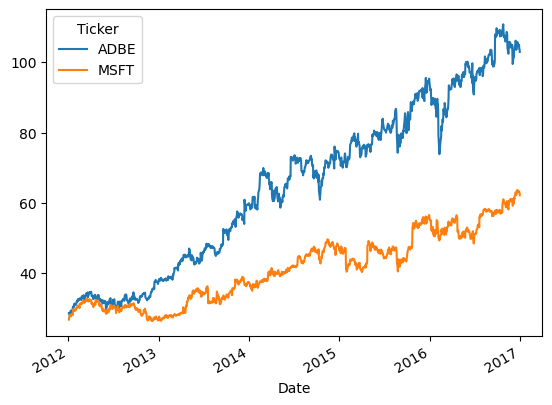

In [20]:
df.plot()
df.describe()

In [21]:
S1 = df['ADBE']
S2 = df['MSFT']

score, pvalue, _ = sm.tsa.stattools.coint(S1,S2)
pvalue

0.029287875832369244

Hence the stocks are cointegreated

# helper functions

In [22]:
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]

    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]

    spread_lag2 = sm.add_constant(spread_lag)

    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))

    if halflife <= 0:
        halflife = 1
    return halflife

#--------------------------------------------------------------------------------------

def KalmanFilterAverage(x):
    # Construct a Kalman filter
    init_state = x[0]
    from pykalman import KalmanFilter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = init_state,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

#--------------------------------------------------------------------------------------

#  Kalman filter regression
def KalmanFilterRegression(x,y):

    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

#--------------------------------------------------------------------------------------


<Axes: xlabel='Date'>

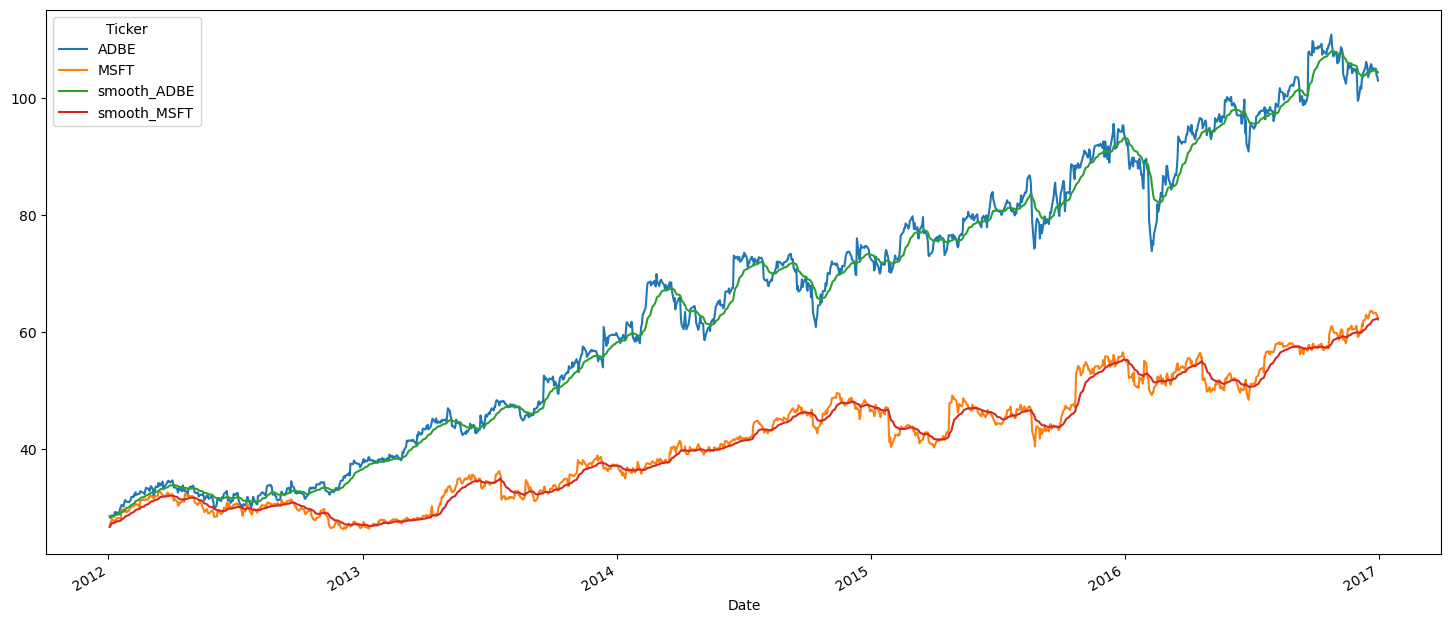

In [23]:
df['smooth_ADBE'] = KalmanFilterAverage(df['ADBE'])
df['smooth_MSFT'] = KalmanFilterAverage(df['MSFT'])
df.plot(figsize=(18,8))

We can observe that there is very little lag (compared to exponential moving avg) in the smooth versions obtained usign kalman filtering

<Axes: xlabel='Date'>

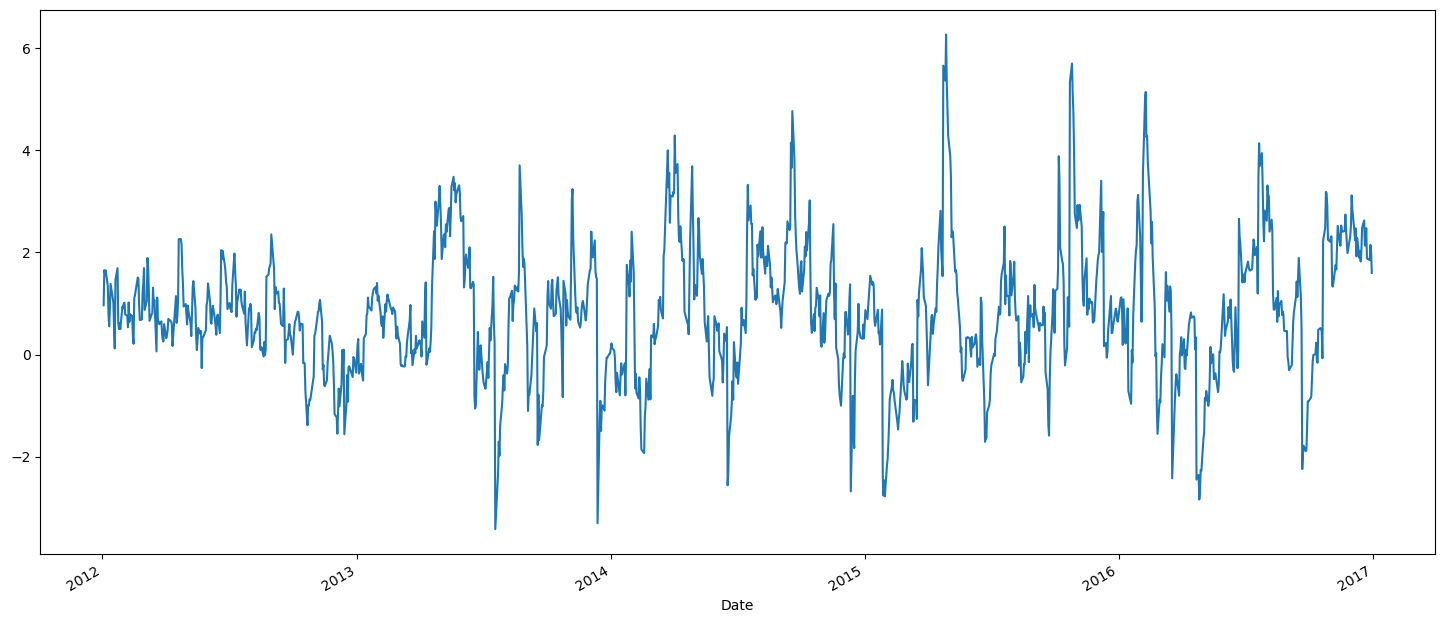

In [24]:
state_means = KalmanFilterRegression(df['smooth_ADBE'],df['smooth_MSFT'])
df['hr'] = state_means[:,0]
df['spread'] = df['MSFT'] - df['hr']*df['ADBE']
df['spread'].plot(figsize=(18,8))

This is the spread calculated dynamically using kalman filtering

In [25]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

hurst(df['spread'].values)

0.13848962393828887

H < 0.5 denoting a strong mean reverting behaviour 

In [26]:
halflife = half_life(df['spread'])
print(halflife)
halflife = int(halflife*2)
meanSpread = df.spread.rolling(window=halflife).mean()
stdSpread = df.spread.rolling(window=halflife).std()
df['zScore'] = (df.spread-meanSpread)/stdSpread

6


Here half life is taken as double the value to capture a greater context of spread in the zscore for backtesting

(16071.0, 16436.0)

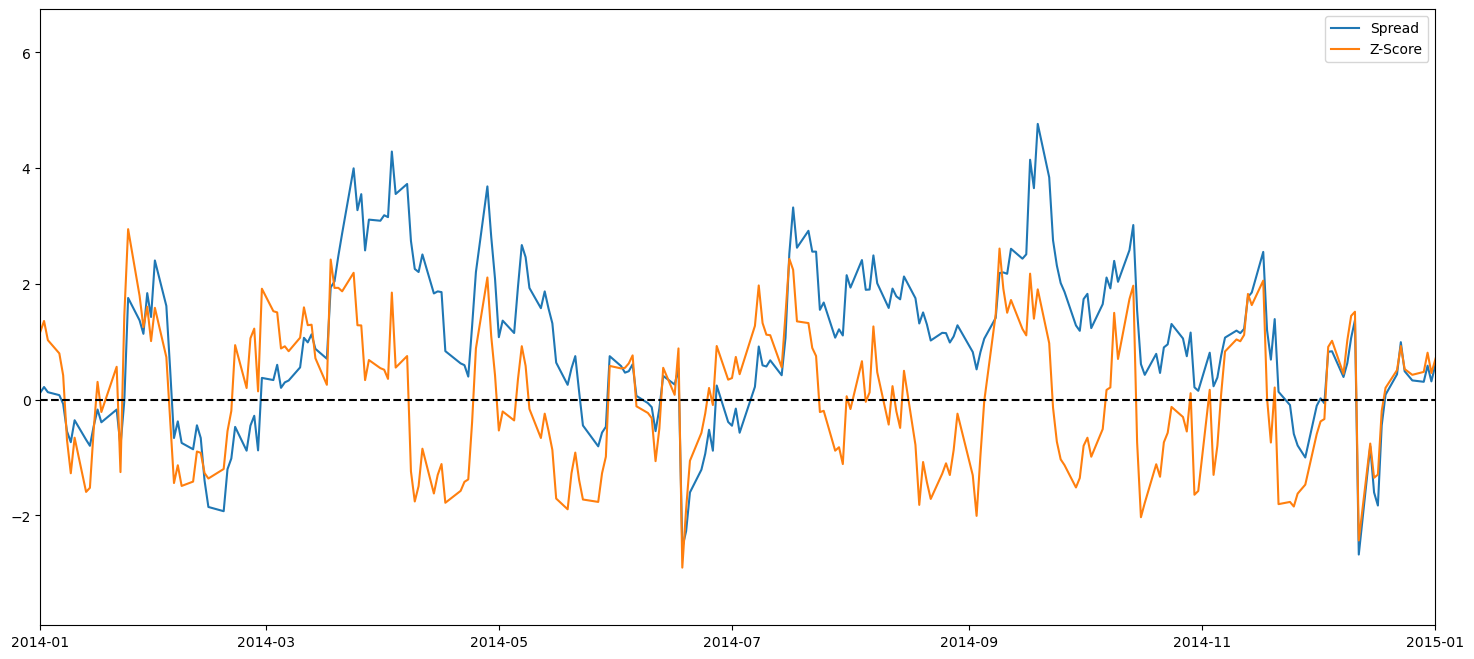

In [27]:
# plot the spread and zscore
plt.figure(figsize=(18,8))
plt.plot(df['spread'])
plt.plot(df['zScore'])
plt.legend(['Spread', 'Z-Score'])
plt.axhline(0, color='black', linestyle='--')
plt.xlim([datetime.datetime(2014, 1, 1), datetime.datetime(2015, 1, 1)])


The zscore is calculated using a window of 2*halflife of spread. Here the spread and zscore can be seen to be similar in terms of the +ve and -ve deviations from the mean. Hence the trades made are correct with respect too the spread as well.

## Backtesting

Here trading signals are generated using the zscore of the spread which is dynamically calculated based on the previous data using kalman filter. Now since this spread is mean reverting, trading signals are generated by checking its deviation from the mean. A long entry is position is taken when the zscore of the spread moves from -entryZscore towards 0. And this position is exited when the zscore moves from -exitZscore towards 0. Similarly short entry is taken when the zscore of the spread moves from +entryZscore towards 0. And this position is exited when the zscore moves from +exitZscore towards 0. 

Similarly taking the entryZscore to be (4/3)*entryZscore [the 4/3 found empirically] and then if the above conditions again hold then the volume of the long or short positions is douobled. This ensures that if the spread deviates from the mean too much then we have a larger number of stocks in the long or short position as the spread is more likely to revert to mean now.

The long and short positions are taken with the hedge ratio as the beta value obtained form kalman filtering which changes dynamically.

A transaction cost of 0.01% is added per transaction.

The trade_pnl is updated at every exit of position in the market. Hence the cumulative pnl is blocky as it gets updated only at certain intervals (exit of position in the market).

Here the entryZscore = (varience of 40 day window of the zscore)*1.5
      and exitZscore = 0

This dynamically changing threshold of entryZscore helps in capturing the market volatility. When the varience is high we have higher threasholds for trading which decreases the amounts of trades in a volatile market and thus reduces the exposure to market risks. This also improves the pnl gained.

The following is based on a max trade volume of 100\*2. So for the estimating % returns we can use 200\*(avg price of the stocks) as the initial investment. That is 10,000 which yeilds 6000 over a period of 5 yrs(see graph below). With a static threshold of 2 for entryZscore gives a return of 3000 as opposed to 6000 now.

Abnormal return dates:  [Timestamp('2014-09-08 00:00:00')]


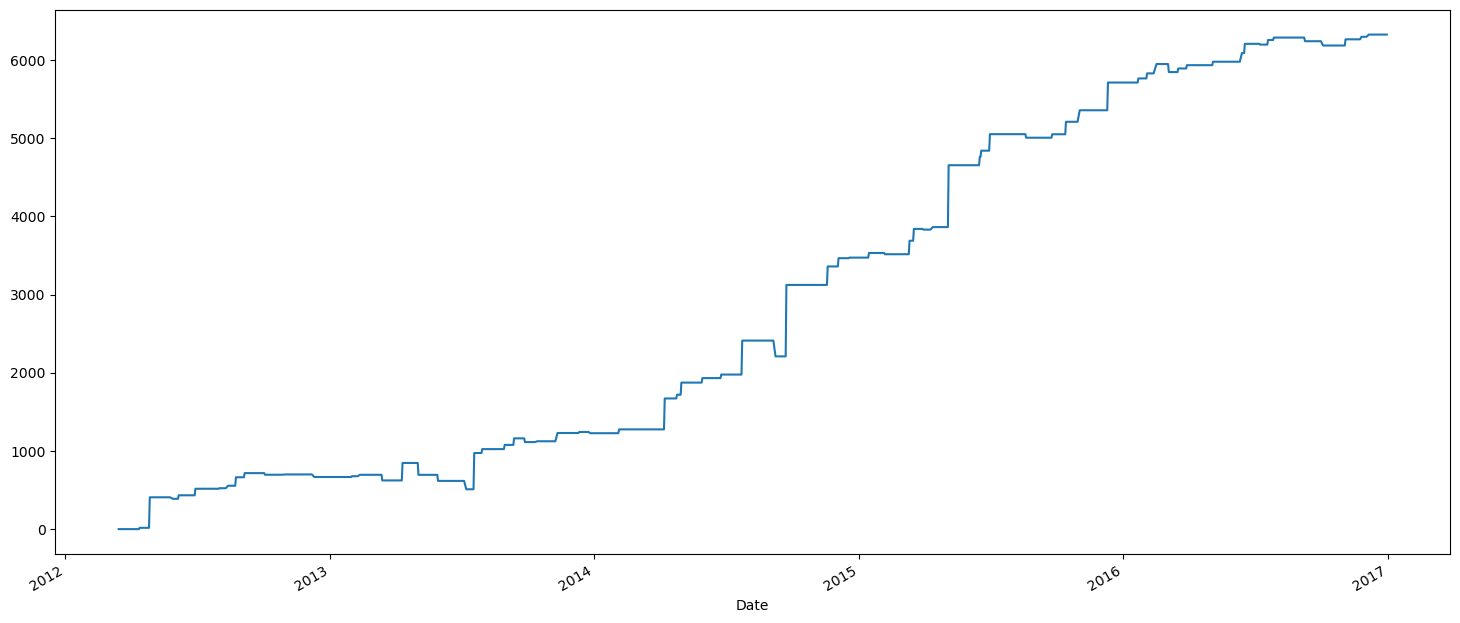

In [28]:
#thresholds
df['entryZscore'] = (df['zScore'].rolling(window=40).std())*1.5
df['exitZscore'] = 0

# geenerate signals
df['long entry'] = ((df.zScore > - df['entryZscore']) & ( df.zScore.shift(1) < - df['entryZscore']))
df['long exit'] = ((df.zScore > - df['exitZscore']) & (df.zScore.shift(1) < - df['exitZscore']))
df['short entry'] = ((df.zScore <  df['entryZscore']) & ( df.zScore.shift(1) > df['entryZscore']))
df['short exit'] = ((df.zScore < df['exitZscore']) & (df.zScore.shift(1) > df['exitZscore']))
df['exit'] = df['long exit'] | df['short exit']
df['long entry'] = (df['long entry'] & df['exit']) ^ (df['long entry'])
df['short entry'] = (df['short entry'] & df['exit']) ^ (df['short entry'])
df['actual_exit'] = False

trade_volume = 100

df.dropna(inplace=True)

long_entry_bool = False
short_entry_bool = False
transaction_cost = 0.0001
wallet = 0 # keep track of money until a market position is closed

# Initialize columns if not already present
df['num MSFT stocks'] = 0  # Position in MSFT
df['num ADBE stocks'] = 0  # Position in ADBE
df['trade_pnl'] = 0        # Trade profit and loss

abnormal_return = []

# Iterate over rows in the DataFrame
for current_date in df.index:
    prev_date = df.index[df.index.get_loc(current_date) - 1]  # Get previous date
    # Check long entry
    if df.loc[current_date, 'long entry']:
        long_entry_bool = True
        df.loc[current_date, 'num MSFT stocks'] = trade_volume
        df.loc[current_date, 'num ADBE stocks'] = -df.loc[current_date, 'hr'] * trade_volume
        wallet += trade_volume * ( -df.loc[current_date, 'MSFT'] + df.loc[current_date, 'ADBE'] * df.loc[current_date, 'hr']) * (1 - transaction_cost)
    
    # Check long exit
    elif df.loc[current_date, 'long exit'] and long_entry_bool is not False:
        df.loc[current_date, 'actual_exit'] = True
        df.loc[current_date, 'trade_pnl'] = wallet + (
            df.loc[current_date, 'MSFT'] * df.loc[prev_date, 'num MSFT stocks'] +
            df.loc[current_date, 'ADBE'] * df.loc[prev_date, 'num ADBE stocks']
        ) * (1 - transaction_cost)  # Subtract transaction cost
        df.loc[current_date, 'num MSFT stocks'] = 0
        df.loc[current_date, 'num ADBE stocks'] = 0
        long_entry_bool = False
        wallet = 0
        if(df.loc[current_date, 'trade_pnl']<-200): # abnormal return
            abnormal_return.append(current_date)
    
    # Check short entry
    elif df.loc[current_date, 'short entry']:
        short_entry_bool = True
        df.loc[current_date, 'num MSFT stocks'] = -trade_volume
        df.loc[current_date, 'num ADBE stocks'] = df.loc[current_date, 'hr'] * trade_volume
        wallet += trade_volume * ( df.loc[current_date, 'MSFT'] - df.loc[current_date, 'ADBE'] * df.loc[current_date, 'hr']) * (1 - transaction_cost)
    
    # Check short exit
    elif df.loc[current_date, 'short exit'] and short_entry_bool is not False:
        df.loc[current_date, 'actual_exit'] = True
        df.loc[current_date, 'trade_pnl'] = wallet + (
            df.loc[current_date, 'MSFT'] * df.loc[prev_date, 'num MSFT stocks'] +
            df.loc[current_date, 'ADBE'] * df.loc[prev_date, 'num ADBE stocks']
        ) * (1 - transaction_cost)  # Subtract transaction cost
        # Reset positions
        df.loc[current_date, 'num MSFT stocks'] = 0
        df.loc[current_date, 'num ADBE stocks'] = 0
        short_entry_bool = False
        wallet = 0
        if(df.loc[current_date, 'trade_pnl']<-200): # abnormal return
            abnormal_return.append(current_date)

    # Carry forward positions
    else:
        if df.index.get_loc(current_date) > 0:  # Skip the first row
            df.loc[current_date, 'num MSFT stocks'] = df.loc[prev_date, 'num MSFT stocks']
            df.loc[current_date, 'num ADBE stocks'] = df.loc[prev_date, 'num ADBE stocks']

            if(((df.loc[current_date, 'zScore'] > - df.loc[current_date, 'entryZscore']*2/1.5) & ( df.loc[prev_date, 'zScore'] < - df.loc[current_date, 'entryZscore']*2/1.5))) and long_entry_bool is not False:
                df.loc[current_date, 'num MSFT stocks'] += trade_volume
                df.loc[current_date, 'num ADBE stocks'] -= df.loc[current_date, 'hr'] * trade_volume
                wallet += trade_volume * ( -df.loc[current_date, 'MSFT'] + df.loc[current_date, 'ADBE'] * df.loc[current_date, 'hr']) * (1 - transaction_cost) 
                
            elif(((df.loc[current_date, 'zScore'] < df.loc[current_date, 'entryZscore']*2/1.5) & ( df.loc[prev_date, 'zScore'] > df.loc[current_date, 'entryZscore']*2/1.5))) and short_entry_bool is not False:
                df.loc[current_date, 'num MSFT stocks'] -= trade_volume
                df.loc[current_date, 'num ADBE stocks'] += df.loc[current_date, 'hr'] * trade_volume 
                wallet += trade_volume * ( df.loc[current_date, 'MSFT'] - df.loc[current_date, 'ADBE'] * df.loc[current_date, 'hr']) * (1 - transaction_cost)
                
# Calculate cumulative PnL
df['Cumulative_PnL'] = df['trade_pnl'].cumsum()

df.dropna(inplace=True)
df['Cumulative_PnL'].plot(figsize=(18,8))

print("Abnormal return dates: ", abnormal_return)


We can see that this strategy manages to get good profits

### Risk-adjusted Returns

Sharpe ratio:  0.5260150582408993
Sortino ratio:  6.0855999671548515
Maximum drawdown:  -336.64456610472155


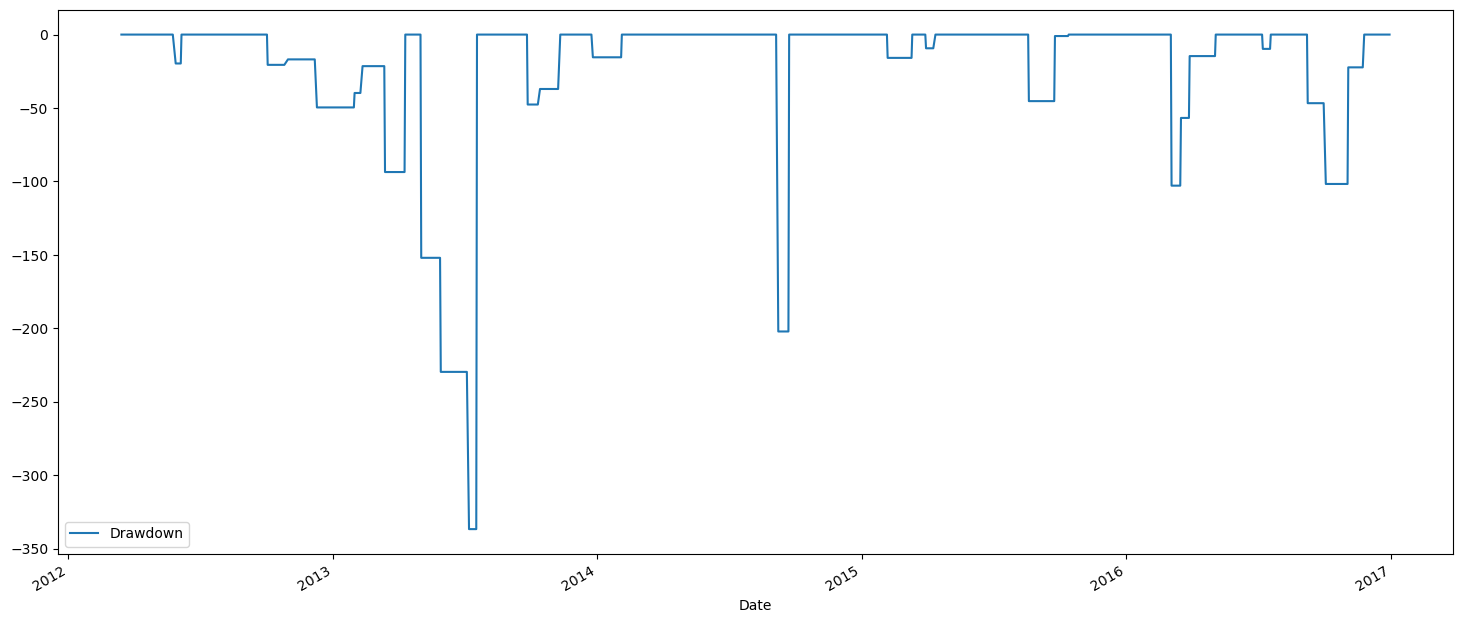

In [29]:
# Calculate the Sharpe ratio
daily_return = df['Cumulative_PnL'].pct_change().dropna()
daily_return = daily_return[1:] # drop the first row as it will be infi
sharpe_ratio = daily_return.mean() / daily_return.std() * np.sqrt(252)
print("Sharpe ratio: ", sharpe_ratio)

# calculate sortino ratio
sortino_ratio = daily_return.mean() / daily_return[daily_return<0].std() * np.sqrt(252)
print("Sortino ratio: ", sortino_ratio)

# plot the drawdown curve
df['Drawdown'] = df['Cumulative_PnL'] - df['Cumulative_PnL'].cummax()
df['Drawdown'].plot(figsize=(18,8))
plt.legend()

# Calculate the maximum drawdown
max_drawdown = df['Drawdown'].min()
print("Maximum drawdown: ", max_drawdown)


Here the sharpe ratio is 0.52 but that is due to way in which the PnL is calculated. The PnL is calcualted when the position in the market is exited. Due the this the PnL is updated (the actual PnL gets reflected) at every exit and stays constant in between. This causes the percentage change in the cumulative PnL to be high at these points and hence increasing the variaence. Most of the changes are positive though that is profit is earned when a position is exited. Using sortino which only reflects the negetive returns we can see that that we have high risk adjusted returns

The drawdown graph again reflects the same thing with it being blocky due to the PnL being updated only at exits.

The max drawdown of 336 is resonable considering the over all profit of 6000.

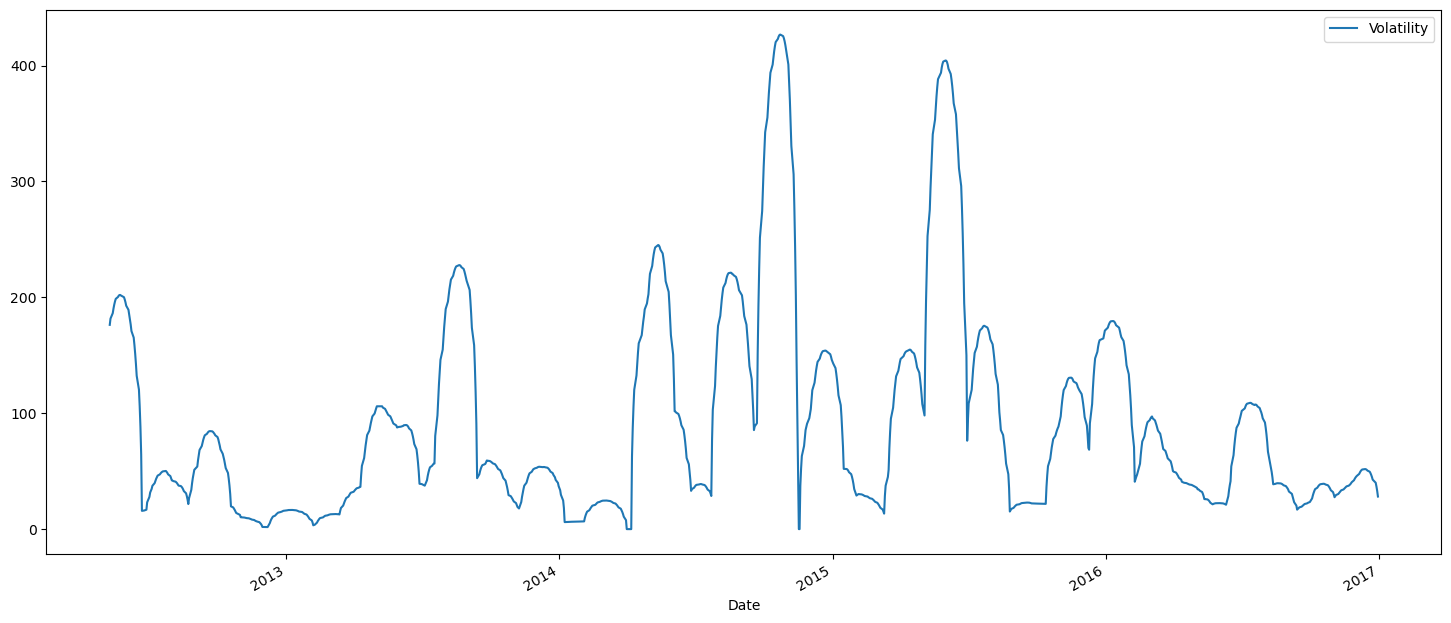

In [30]:
# plot the volatility curve of pnl for a rolling window of 30 days
df['Volatility'] = df['Cumulative_PnL'].rolling(window=40).std()
df['Volatility'].plot(figsize=(18,8))
plt.legend()


This is the volatility in the pnl using a 40 day window. The highest value of 400 standard deviation is resonable considering the profit.

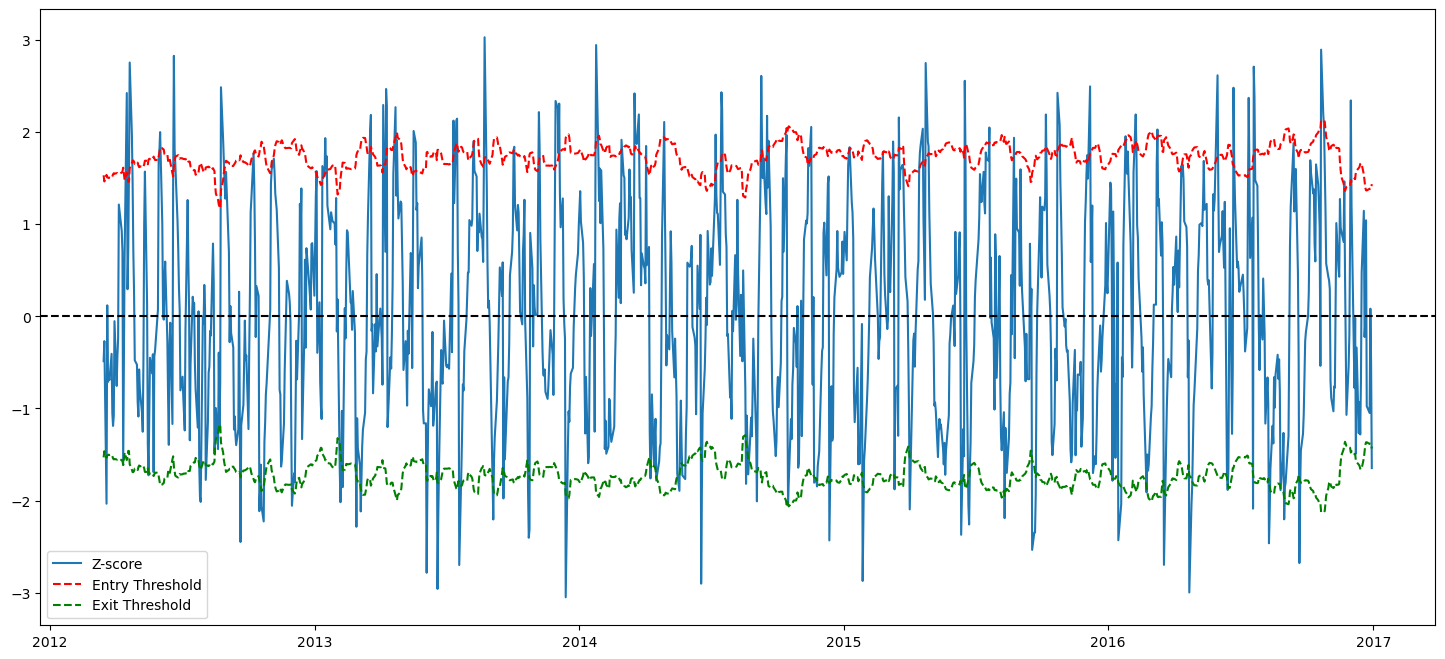

In [31]:
# plot the zscore along with the threshold
plt.figure(figsize=(18,8))
plt.plot(df['zScore'])
plt.plot(df['entryZscore'], color='red', linestyle='--')
plt.plot(-df['entryZscore'], color='green', linestyle='--')
plt.legend(['Z-score', 'Entry Threshold', 'Exit Threshold'])
plt.axhline(0, color='black', linestyle='--')

We can observe the varying of threshold for trading signals based on the market volatility.

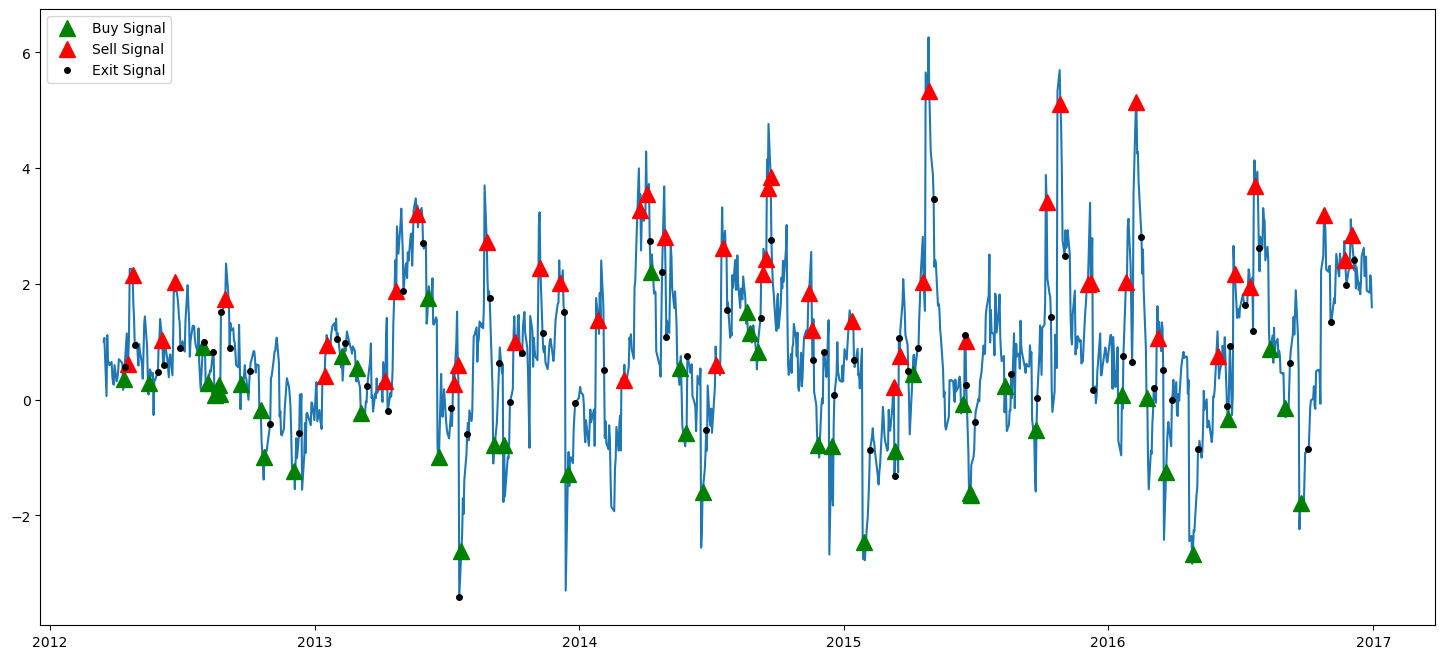

In [32]:
# plot the buy and sell signals and exit on the spread
plt.figure(figsize=(18,8))
plt.plot(df['spread'])
plt.plot(df[df['long entry']].index, df['spread'][df['long entry']], '^', markersize=12, color='g', lw=0, label='Buy Signal')
plt.plot(df[df['short entry']].index, df['spread'][df['short entry']], '^', markersize=12, color='r', lw=0, label='Sell Signal')
plt.plot(df[df['actual_exit']].index, df['spread'][df['actual_exit']], '.', markersize=8, color='k', lw=0, label='Exit Signal')
plt.legend(loc='upper left')
plt.show()


Here we can observe that the strategy in general manages to buy the spread at low price(spread) and sell high. which gives a sanity check on our calculations.

All the above analysis was done by fixing the tradable volume to 200. This can be different based in risk apetite and investment ability. This can also be dynamically changes using some rule to further get better risk adjustment and returns.

To summarize, we have achieved good risk adjustedd returns by implementing kalman filtering for pairs trading. Using dynamically changing threshold for trading signals as well as using 2 differet levels for long and short position with larger position taken for higher thresholds to increase profits and reduce risk.